# MHD HW 4 Dino Bektesevic

## Problem 2. Write  a  program  to  solve  the  1  dimensional  Euler  equation  using  a finite  difference  algorithm.  

The system is governed by the following Euler equations in 1D: 

$$
\frac{\partial}{\partial t} \begin{bmatrix} \rho \\
\rho v \\
\rho E
\end{bmatrix} + \frac{\partial}{\partial x}\begin{bmatrix} \rho v \\
\rho v^2 + P \\
\rho v \left ( E + \frac{P}{\rho}\right )
\end{bmatrix} = 0
$$

We set the following initial conditions: the length of tube $L=1$, the gas is monotonic and adiabatic $\gamma=5/3$, the step size we parametrize according to the number of steps $N$ we want to take such that $dx = L/(N-1)$. To the left of the membrane initially $\rho_{left} = 1$, $P_{left}=1$ and $v_{left} = 0$. To the right of the membrane $\rho_{right}=0.125$, $P_{right}=0.1$. We take the time step to be $dt=0.25$.


To help us solve the case numerically we rewrite the starting Euler equations as:
$$ \frac{\partial}{\partial t} f + \frac{\partial}{\partial x} F = 0$$
so that 
$$ f = \begin{bmatrix} \rho \\
\rho v \\
\rho E
\end{bmatrix} \\
F = \begin{bmatrix} \rho v \\
\rho v^2 + P \\
\rho v \left ( E + \frac{P}{\rho}\right )
\end{bmatrix}
$$

Now we can write the first order approximation to the problem by applying the Lax-Friedrichs difference technique as:
$$f_{j+1,k} = \frac{f_{j,k-1}+f_{j,k+1}}{2} - \frac{\partial t}{2\partial x}\left(F_{j,k+1}-F_{j,k-1} \right)$$
In practical terms we evaluate the expression as follows:
* using $f_{j,k}$ evaluate $F_{j,k}$ for all $k$ 
* evaluate $f_{j,k\pm1}$ 
* calculate $F$ by using $f_{j,k\pm1}$
* update $f_{j+1,k}$ by using $F$ 

For the first step initial conditions set the $f_{0,k}$ which evolves later. The second and third steps are then evaluating the spatial steps $f_{j,k\pm1}$ and $F_{j,k\pm1}$ which are required to evaluate the next time step. The last step is to calculate the following time step $f_{j+1,k}$. Once we return back to the first point, however, because we have updated the time step $f_{j+1,k}$ the evaluation of $F$ will now happen at $F_{j+1,k}$ thus chaining our simulation untill it is stopped by other imposed conditions. It is important to constantly update the boundary conditions as they change (or not) through the simulation.

In class we derived the Courant condition, which gives us the limit of our step $dt$ in which this approximation will remain valid:
$$\Delta t \le \frac{\Delta x}{|v|}$$
or more precisely
$$\Delta t \le \min{\frac{\Delta x}{\sqrt{v^2+c_S^2}}}$$
which we will use to dynamically adjust our time step as we are progressing through the simulation so that we do not disturb the genies of numerical stability. The velocity $v$ is calculated through the Euler equations of the system and the speed of sound $c_S$ is calculated as:
$$ c_S = \sqrt{\gamma\frac{|P|}{\rho}}$$
With what was described so far we can confidently define the following functions that calculate the speed of sound, pressure, energy, specific energy and specific entropy. We will need these values for the plots and they will make the rest of the code easier to write too so we start from them.

In [190]:
import numpy as np

def c_S(P, rho, gamma):
    """Calculates speef of sound in a medium."""
    return np.sqrt( gamma * np.abs(P)/rho )

def pressure(E, rho, v, gamma):
    """Calculate pressure given energy, density and velocity."""
    return (gamma-1) * (E - (rho/2)*v**2)

def energy(P, rho, v, gamma):
    """Calculate total energy."""
    return 1/2 * rho * v**2 + P/(gamma-1)

def e_spec(P, rho, gamma):
    """Calculate specific internal energy."""
    return P/( (gamma-1)*rho )

def s_spec(P, rho, gamma):
    """Calulate specific entropy."""
    return P**(gamma-1)/rho

To implement the numerical solution described above easily we can use the numpy arrays and their magic to do in-place calculations for each spatial and temporal step. For a simulation with 2 time steps 3 spatial steps each simulted quantity can be represented by a 2D matrix where first index runs over temporal coordinate and the second index runs over spatial coordinate. The system matrices f and F are then 3D matrices where first index runs over different variables ($\rho$, $v$, $E$ etc.). For example, for this simplified case the initial state of the system would look like:
$$
\begin{align}
\begin{bmatrix} 
    \begin{bmatrix}   
        \begin{pmatrix}1 & 1 & 0.125 \end{pmatrix}_{t=0} \\
        \begin{pmatrix}0_{x_1} & 0_{x_2} & 0_{x_3} \end{pmatrix}_{t=1}
    \end{bmatrix}_{\rho} \\
    \cdots \rho v\\
    \cdots \rho E
\end{bmatrix}
\end{align}
$$
This is useful as then the numpy array indices match the indices from the equations. Now we can define the setup function that will return to us $f$, $F$. 

In [206]:
# initial conditions as provided by the problem
rho_right = 0.125
rho_left  = 1
P_right   = 0.1
P_left    = 1
v_right   = 0.0
v_left    = 0.0
gamma     = 5/3

# defining the tube geometry, partially provided by the problem
Ncoordsteps = 3000
Ntimesteps  = 3000
L   = 1
dx  = L/(Ncoordsteps - 1)
x_0 = Ncoordsteps//2 # middle of the tube

In [207]:
def setup(Ntimesteps, Ncoordsteps):
    """Sets up the intial system by using the given (globaly defined)
    initial conditions and returns the matrices f and F describing the
    system.
    """
    # unlike other functions this one depends on globally defined vars
    # this is bad saves a lot of additional writing.
    f = np.zeros((3, Ntimesteps, Ncoordsteps))
    F = np.zeros((3, Ntimesteps, Ncoordsteps))
    
    # density
    f[0, 0, x_0:] = rho_right
    f[0, 0, :x_0] = rho_left
    
    # density * velocity
    f[1, 0, x_0:] = rho_right * v_right
    f[1, 0, :x_0] = rho_left  * v_left
    
    # energy 
    f[2, 0, x_0:] = energy(P_right, rho_right, v_right, gamma)
    f[2, 0, :x_0] = energy(P_left,  rho_left,  v_left, gamma)
    
    dt = dx/c_S(f, 0, gamma)
    
    return f, F

Before we can write the solver it's also practical to define a function that will separate each of the system variables ($\rho$, $v$, $E$ etc.) from $f$ into separate array so it's easier to work with. We need a function that will enable us to calculate the time step $dt$ that satisfies the Courant condition. A function that will update the boundary values, which will change as the system evolves is also required.

In [208]:
def separatef(f, j, gamma):
    """Returns variables (rows) of f matrix as individual 
    matrices (ndarrays) for a given time-stamp j and
    additionally calcuates pressure and velocity at that 
    time-stamp for all spatial coordinates.
    """
    rho  = f[0, j, :]
    rhov = f[1, j, :]
    E    = f[2, j, :]
    v    = rhov/rho
    P    = pressure(E, rho, v, gamma)
    return rho, rhov, E, v, P

In [209]:
def vcourant(f, j, gamma):
    """Calculates the velocity that satisfies the Courant conditions
    for a particular time step j.
    """
    rho, rhov, E, v, P = separatef(f, j, gamma)
    # find the index of the largest v
    vmax_k = np.argmax(np.abs(v))
    vmax = v[vmax_k]
    # calculate the speed of sound
    cs = c_S(P[vmax_k], rho[vmax_k], gamma)
    return np.abs(vmax)+cs 

In [210]:
def updateBoundaries(f, j):
    """Updates the boundary conditions at a time coordinate j."""
    f[0, j, 0] = f[0, j, 1]
    f[1, j, 0] = -f[1, j, 1]
    f[2, j, 0] = f[2, j, 1]
    
    f[0, j, -1] = f[0, j, -2]
    f[1, j, -1] = -f[1, j, -2]
    f[2, j, -1] = f[2, j, -2]

Finally a function that evaluates $F$ for a timestep $j$ is the last thing we also need and now we can finally write our Lax-Friedrichs solver.

In [211]:
def Fj(f, F, j, gamma):
    """Calculates values F_{j, k} for a particular time 
    coordinate j in all spatial coordinates k. Calculation
    is performed in-place for F.
    """
    rho, rhov, E, v, P = separatef(f, j, gamma)
    F[0, j, :] = rho*v
    F[1, j, :] = rho*v**2 + P
    F[2, j, :] = v*(E+P)

In [212]:
def solver_LaxFriedrichs(f, F):   
    """ A PDE solver based on the Lax-Friedrichs method of approximating
    the PDE sollution.
    """
    # this function will also depend on global vars because signature would get long
    f_half = np.zeros([3, Ntimesteps, Ncoordsteps])
    F_half = np.zeros([3, Ntimesteps, Ncoordsteps])
    time   = np.zeros(Ntimesteps)
    
    dt = dx/vcourant(f, 0, gamma) 
    time[0]= dt
    
    for j in range(Ntimesteps-1):
        # evaluate F for all positions k at curent time j
        Fj(f, F, j, gamma)
        
        # evaluate f at all k's except boundaries at current time j
        firstpart  = (f[:, j, 2:] + f[:, j, 1:-1])/2  
        secondpart = dt/(2*dx) * (F[:, j, 2:] - F[:, j, 1:-1])
        f_half[:, j, 1:-1] = firstpart - secondpart
        
        # update boundary values
        updateBoundaries(f_half, j)
        
        # calculate F for new boundaries and f
        Fj(f_half, F_half, j, gamma)
        
        # calculate f for the next time step
        firstpart  = f[:, j, 1:-1]  # + U[:, j, 1:-1])/2  
        secondpart = dt/(dx) * (F_half[:, j, 1:-1] - F_half[:, j, :-2])
        f[:, j+1, 1:-1] = firstpart - secondpart
        
        # update boundaries again
        updateBoundaries(f, j+1)
        
        # calculate next dt satisfying Courant
        dt = dx/vcourant(f, j+1, gamma)
        time[j+1] = time[j]+dt
    return time

In [ ]:
f, F = setup(Ntimesteps, Ncoordsteps)
time = solver_LaxFriedrichs(f, F)

### Plot the results

In [204]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["text.usetex"] = True
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams["axes.grid"] = True
plt.rcParams['font.size'] = 20

In [201]:
# we pick at what time do we want to plot our results
t = np.where(time > 0.25)[0][0]

# the x axis will be just the tube length
x = np.linspace(0, L, Ncoordsteps)

# the y axis are our system qunatities
rho, rhov, E, v, P = separatef(f, t, gamma)
eps = e_spec(P, rho, gamma)
sspec = s_spec(P, rho, gamma)
yvals = [rho, E, v, P, eps, sspec]
ylabels = [r"$\rho$", r"$E$", r"$v$", r"$P$", r"$\epsilon$", r"$s$"]

# eyeballed the vline values
vlinescoords = [x[x_0], 0.17, 0.96]
vlineslabels = ["Barrier", "Rarefaction", "Shock"]
vlinetypes   = ["solid", "dashed", "dashdot"]

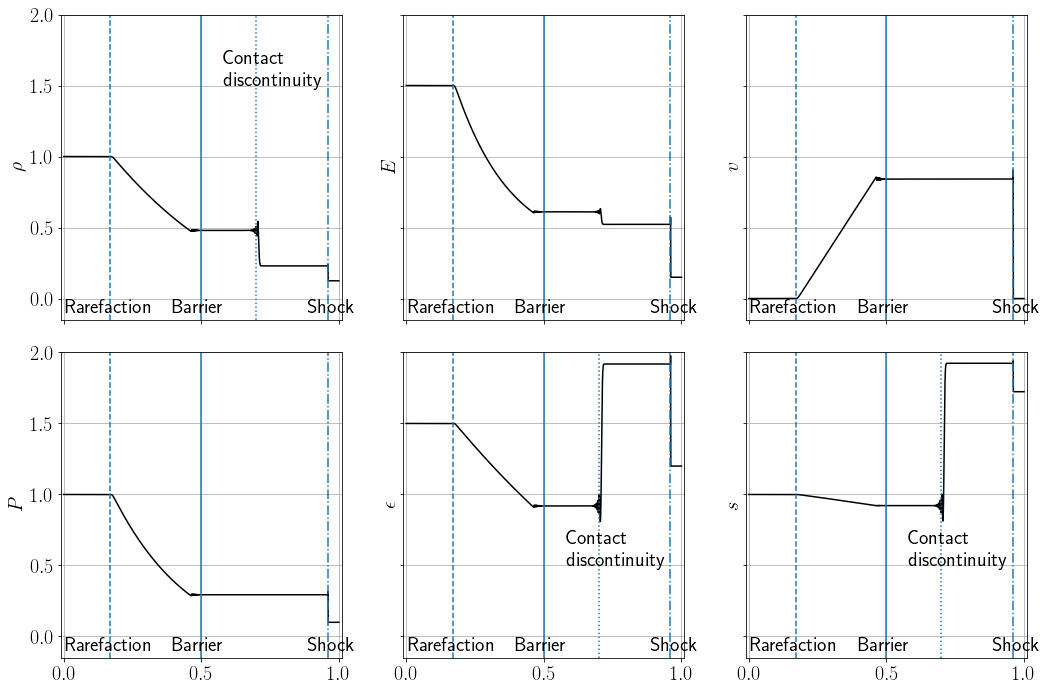

In [214]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

i = 0
for axy in axes:
    for axx in axy:
        axx.plot(x, yvals[i], label=ylabels[i], color="black")
        axx.set_xlim(-0.01, 1.01)
        axx.set_ylim(-0.15, 2)
        axx.set_ylabel(ylabels[i])                
        for (vcoord, vtext, linetype) in zip(vlinescoords, vlineslabels, vlinetypes):
            axx.axvline(vcoord, ls=linetype, label=vtext)
            # 0.03 is about 1 letter wide at this font so 1/2 * 0.3*len(vtext)) is 0.5 word width
            offset = 0.5 * 0.03*len(vtext)
            axx.text(vcoord-offset, -0.1, vtext)
            
        i+=1
        
# the additional vertical lines are manually plotted, eyeballs again
vcoord = 0.8
linetype = "dotted"
vtext = "Contact\ndiscontinuity"
offset = 0.35 * 0.03*len(vtext)

axes[0,0].axvline(0.7, ls=linetype, label="Contact\nDiscontinuity")
axes[0,0].text(vcoord-offset, 1.5, vtext)
axes[1,1].axvline(0.7, ls=linetype, label="Contact\nDiscontinuity")
axes[1,1].text(vcoord-offset, 0.5, vtext)
axes[1,2].axvline(0.7, ls=linetype, label="Contact\nDiscontinuity")
axes[1,2].text(vcoord-offset, 0.5, vtext)
            
plt.tight_layout()

## Problem 1.

Resuming from the Euler's approximations fo a 1D problem and deriving the expressions for $F$
$$\frac{\partial}{\partial t} f + \frac{\partial}{\partial x} F = 0$$

$$
\frac{\partial}{\partial t}
    \begin{bmatrix} 
        \rho \\
        \rho v \\
        \rho E
    \end{bmatrix}
+ \frac{\partial}{\partial x}
    \begin{bmatrix} \rho v \\
        \rho v^2 + P \\
        \rho v \left ( E + \frac{P}{\rho}\right )
    \end{bmatrix}
= 0
$$


$$
\frac{\partial}{\partial t}
    \begin{bmatrix} 
        \rho \\
        v \\
        P
    \end{bmatrix}
+ \begin{bmatrix} 
     v & \rho                     & 0      \\
     0 &   v                      & 1/\rho \\
     0 & \rho\gamma\frac{P}{\rho} &  v     \\
\end{bmatrix}
\frac{\partial}{\partial x}
    \begin{bmatrix} 
        \rho \\
        v \\
        P
    \end{bmatrix}
= 0 
$$

we recognize the $c_S^2 = \gamma\frac{P}{\rho}$, $f = \begin{bmatrix} \rho \\ u \\ P \end{bmatrix} $ and rewrite the expression as: 

$$ \frac{\partial}{\partial t} f + J \frac{\partial}{\partial x}f = 0 $$

where $J$ is the matrix

$$ J =
\begin{bmatrix} 
     v & \rho       & 0      \\
     0 &   v        & 1/\rho \\
     0 & \rho c_S^2 &  v     \\
\end{bmatrix}
$$

following the procedure we need to solve the characteristic equation of the system:

$$ |J^T - \lambda I| = 0$$

$$
\begin{vmatrix} 
     v-\lambda &   0       &     0      \\
       \rho    & v-\lambda & \rho c_S^2 \\
        0      & 1/\rho    &  v-\lambda \\
\end{vmatrix} = 0
$$

thankfully only the first row, first column $v-\lambda$ expressions survive giving us:
$$\begin{eqnarray}
(v-\lambda)(v-\lambda)(v-\lambda) - (v-\lambda)\rho c_S^2\frac{1}{\rho} &=& 0 \\
(v-\lambda)\left[(v-\lambda)^2 - c_S^2\right] &=& 0 
\end{eqnarray}$$

from which we find three eigenvalues of the matrix $J$:
$$\begin{eqnarray}
(v-\lambda) &=& 0 &\rightarrow& \lambda_1 = v \\
(v-\lambda)^2 - c_S^2 &=& 0  &\rightarrow& \lambda_{2,3} = v \pm c_S
\end{eqnarray}$$

From this point on I do not really understand what the method of characteristics has us do. But what I can make out from Tom's notes is that we pick the positive eigenvalue $\lambda_{2,3} = v + c_S$ and write out the the mass conservation law, the the momentum conservation law (I think) and then add that to the 1D Euler equation without gravity:

$$\frac{D\rho}{Dt} + \rho \frac{\partial v}{\partial x} = 0$$

$${c_S}^2\frac{D\rho}{Dt} = \frac{Dp}{Dt}$$

$$\frac{\partial v}{\partial t} + v \frac{\partial v}{\partial x} + \frac{1}{\rho}\frac{\partial p}{\partial x} = 0$$

we substitute (2) into (1) and then add them with (3), rearange and get 

$$ \left[ \frac{\partial v}{\partial t} + (v+c_S)\frac{\partial v}{\partial x} \right] + 
\frac{1}{\rho c_S} \left[ \frac{\partial p}{\partial t} + (v+c_S)\frac{\partial p}{\partial x} \right]
= 0$$

we define a thing called Riemann invariant:

$$J_+ = v + \int \frac{dp}{\rho c_s}$$

from which for an isentropic case ($P$ is a function of $\rho$ only).

$$J_+ = v + \frac{2c_S}{\gamma -1}$$

Now this looks suspiciously similar to our eigenvalues, but I can't particularily make the connection from what's in the book (that seems to be just stating the eigenvalues equal to ours) and what we calculated here and how would this transfer over for a different egenvalues). Moving on, however, we can claim that since this is an invariant we can set it equal to each other. 

$$v_{left} + \frac{2{c_S}_{left}}{\gamma -1} = v + \frac{2c_S}{\gamma -1}$$

plugging in the $c_S^2 = \gamma\frac{P}{\rho}$ and setting the lefthand side $v=0$ (this does not happen for right hand side as is obvious from the plots of the system above). 

$$\sqrt{\gamma\frac{P_{left}}{\rho_{left}}} 
= v + \frac{2}{\gamma -1}\sqrt{\gamma\frac{P}{\rho}}$$

expressing $v$ from that gets us

$$ v = \frac{2}{\gamma -1} \sqrt{  \gamma\frac{P_{left}}{\rho_{left}} - \gamma\frac{P}{\rho}}  $$

from adiabatic gas law we know that $\rho = \rho_{left}\left(\frac{P}{P_{left}}\right)^{\frac{1}{\gamma}}$ 

$$ v = \frac{2}{\gamma - 1} \left[ \frac{P_{left}}{\rho_{left}} - \frac{P}{ \rho_{left}\left(\frac{P}{ P_{left}}\right)^{\frac{1}{\gamma} }  } \right]^{\frac{1}{2}}$$

so we can pull out both $\rho_{left}$ and $\gamma$:

$$ v = \frac{2}{\gamma - 1} \frac{ \gamma^{\frac{1}{2}} }{ \rho_{left}^{\frac{1}{2}} }
\left[ 
P_{left} - \frac{ PP_{left}^{\frac{1}{\gamma}} }{ P^{\frac{1}{\gamma}}  } 
\right]^{\frac{1}{2}}
$$

We notice the following: $P_{left} = P_{left}^{\frac{\gamma-1}{\gamma}}P_{left}^{\frac{1}{\gamma}}$ because $1-\frac{1}{\gamma} = \frac{\gamma-1}{\gamma}$ and that $\frac{ P }{ P^{\frac{1}{\gamma}}} = P^{\frac{\gamma-1}{\gamma}}$ for the same reason. So we can pull out $P_{left}^{\frac{1}{2\gamma}}$ from the brackets (mindfull of the square root):

$$ v = \frac{2}{\gamma - 1} \frac{ \gamma^{\frac{1}{2}} P_{left}^{\frac{1}{2\gamma}} }{ \rho_{left}^{\frac{1}{2}} }
\left[ 
P_{left}^{\frac{\gamma-1}{\gamma}} - P^{\frac{\gamma-1}{\gamma}}
\right]^{\frac{1}{2}}
$$

Which is what the problem has us show.